# SDMT Reliability

## 1. Introduction

The SDMT has proven to be quite useful in neuropsychological MS research. It has excellent test–retest reliability, and alternate forms have been developed that are equivalent in difficulty. When the alternate forms are used, reliability is maintained. Validity research shows that SDMT is a good measure of processing speed or efficiency. SDMT is the neuropsychological test most sensitive to MS cognitive disorder and correlates very well with MRI measures of atrophy, lesion burden, and micro- structural pathology. The test very effectively repre- sents the core neuropsychological domain of processing speed.

In comparison to other digit/symbol substitution tests, the digital version has the following advantages: limited practice effect due to the generation of new keys and forms at each session, standardisation of the presentation, precision in the presentation of the stimulus and scoring of the responses, and immediate classification of each subject score according to normative values


In [2]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from math import *
from scipy.stats import gaussian_kde
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
sys.path.insert(0, '/Users/pedrohserrano/SDMT-Analysis/utils') #internal packages
import buildms as ms 
import statsms as stms
color_ms = '#386cb0' #blue, This is the color chosen for patients with Multiple Sclerosis
color_hc = 'red'#This is the color chosen for health control participants

--- 
### 1.1 Datasets

In [4]:
!python ~/SDMT-Analysis/utils/create_dataset.py ~/SDMT-Analysis/data/processed/mijn-kwik-may.csv

Percetnage of missing values: 26.309124185727793
Max answers: 61
Min score: 7 Max score: 67 Mean score: 45.861979166666664
Percentage of MS in Dataset: 65.0 %
... Dataset df_measures_users.csv created
... Dataset df_measures.csv created
... Dataset df_symbols.csv created


In [5]:
df_measures = pd.read_csv('~/SDMT-Analysis/data/interim/df_measures.csv', encoding="utf-8")

In [12]:
df_measures_users = pd.read_csv('~/SDMT-Analysis/data/interim/df_measures_users.csv', encoding="utf-8")

In [14]:
df_measures_users.rename(index=str, 
                         columns={'userId':'Patient', 'correct.answers':'Average of Correct Answers',
                                  'total.answers':'Average of Total Answers','accuracy.rate':'Correct / Total',
                                  'avg_test_ms':'Average Time of Response Miliseconds',
                                  'hour':'Average Hour of the Day',
                                  'ms':'MS Patient','events':'Number of Trials per Patient',
                                  'correct.answers_median':'Median of Correct Answers',
                                  'timestamp':'Day Experiment Starts','distract_points':'Average of Distract Points'
                                 }).head(8).sort_values(by='Number of Trials per Patient',
                 ascending= False).style.set_properties(**{'text-align': 'center'})

,Patient,Average of Correct Answers,Average of Total Answers,Correct / Total,Average Time of Response Miliseconds,Average Hour of the Day,MS Patient,Number of Trials per Patient,Median of Correct Answers,Day Experiment Starts,Average of Distract Points
0,3ZJxRxNFMbsihHc9n,46.5714,46.7857,0.995363,3739.43,16,1,14,47.5,2017-06-01 10:18:49.461,1.35714
4,9BjE8bBgbi878bLbK,54.5,54.8333,0.994017,3191,11.0833,1,12,55,2017-06-15 10:26:06.894,0.583333
6,BcKgfS2coGNzsd4vJ,40.25,41.5,0.970155,4197.17,15.1667,1,12,40,2017-07-01 16:37:07.867,2.91667
2,6tzxzhSYpdi74TZth,57,57.8182,0.985656,3053.09,16,1,11,56,2017-06-28 15:59:05.888,0.636364
1,3sLik5kugaynxduWs,58.8889,59.2222,0.993975,2961.22,14.5556,0,9,57,2017-07-01 11:19:43.217,1.44444
3,7wCDFJMaqeZnFT93S,52.4444,53.4444,0.981066,3259.78,16.2222,1,9,52,2017-07-07 17:24:13.736,1
5,9G6ytzP9qiBSRDeCF,61,61.8571,0.985758,2879,16.1429,0,7,62,2017-06-14 12:20:32.043,1.42857
7,Dzk7fSkuN94xGo2Nn,58.2,58.8,0.989465,2961,10.4,0,5,60,2017-06-15 20:18:17.095,0.6


---
### 1.2 Study

In [15]:
print('{} Data points distribuited among {} Participants'.format(len(df_measures), len(df_measures_users)))

246 Data points distribuited among 23 Participants


We choose the score variable as the number of correct answers on every test

In [16]:
score_variable = 'correct.answers'

In [17]:
#Method called from the directory
ms_builder = ms.MSscores(df_measures)

In [18]:
df_series, df_days_elapsed = ms_builder.scores_time_series(score_variable)

In [19]:
print('Study performed from {} to {}'.format(min(df_series.index), max(df_series.index)))

Study performed from 2017-05-31 to 2017-08-10


In [20]:
pd.DataFrame(df_days_elapsed.describe().transpose()).mean()

count    9.434783
mean     3.336968
std      1.560051
min      1.434783
25%      2.619565
50%      3.130435
75%      3.815217
max      5.913043
dtype: float64

The data available for the current study is conformed from 31/05/2017 to 10/08/2017 

We expect that every person performs the test within 8 or 10 times, we found $9.47$ on average. 

The number of days of the study on every participant should be 30 days, we found $(9.47*3.33 = 31.55)$ The expected number of trials times the expected days between every trial we can find an inference for the days. 

---
### 1.3 Population

In [21]:
#Split the patients MS (Multiple Sclerosis) and HC (Health Control)
df_ms = df_measures_users[df_measures_users['ms']==1]
df_hc = df_measures_users[df_measures_users['ms']==0]

In [22]:
print('Patients on MS group: {} ({}%)\nPatients on HC group: {} ({}%) '.format(
        len(df_ms), round(len(df_ms)/len(df_measures_users)*100, 0),
        len(df_hc), round(len(df_hc)/len(df_measures_users)*100, 0)))

Patients on MS group: 15 (65.0%)
Patients on HC group: 8 (35.0%) 


In [23]:
print('Average Number of Event per Group \n MS Group: {} (SD {}) \n HC Group: {} (SD {})'.format(
    round(df_ms['events'].mean(),2), round(df_ms['events'].std(),2), 
    round(df_hc['events'].mean(),2), round(df_hc['events'].std(),2))) 

Average Number of Event per Group 
 MS Group: 11.93 (SD 4.59) 
 HC Group: 8.38 (SD 3.11)


In [24]:
scores_sorted = df_measures_users.set_index('userId')[score_variable].sort_values(ascending=False)
ms_labels = [df_measures[df_measures['userId']==user].iloc[0]['ms'] for user in scores_sorted.index]
colores = [color_ms if ms==1 else color_hc for ms in ms_labels]

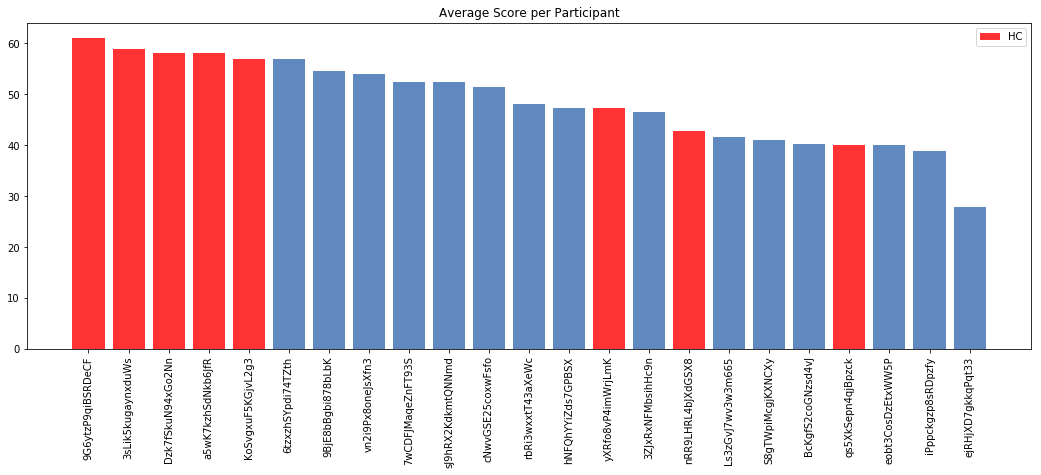

In [105]:
plt.figure(figsize=(18, 6))
position = range(len(scores_sorted.index))
plt.bar(position, scores_sorted, align='center', alpha=0.8, color=colores, label='HC')
plt.xticks(position, scores_sorted.index, rotation=90)
plt.legend(loc='best')
plt.title('Average Score per Participant')
plt.show()

Is clear to see that the people on Health Control group tend to score more comparing with ms group

In [26]:
#Computing intervals for standar error
import scipy.stats as stats

In [27]:
summary_ms = df_ms[score_variable].describe()
sem_ms=stats.sem(df_ms[score_variable])
interval_ms = [summary_ms.loc['mean']-(sem_ms*1.96), summary_ms.loc['mean']+(sem_ms*1.96)]

In [28]:
print('Average Score of MS Group: {} (SD {}) \nSEM (Standard Error): {} \nTrue Score Interval:{}'.format(
    round(summary_ms.loc['mean'],2), round(summary_ms.loc['std'],2) ,round(sem_ms,2), interval_ms))  

Average Score of MS Group: 46.22 (SD 7.88) 
SEM (Standard Error): 2.03 
True Score Interval:[42.2359279085235, 50.211286981849291]


In [29]:
summary_hc = df_hc[score_variable].describe()
sem_hc=stats.sem(df_hc[score_variable])
interval_hc = [summary_hc.loc['mean']-(sem_hc*1.96), summary_hc.loc['mean']+(sem_hc*1.96)]

In [30]:
print('Average Score of HC Group: {} (SD {})\nSEM (Standard Error): {} \nTrue Score Interval:{}'.format(
    round(summary_hc.loc['mean'],2), round(summary_hc.loc['std'],2) ,round(sem_hc,2), interval_hc))

Average Score of HC Group: 52.92 (SD 8.22)
SEM (Standard Error): 2.91 
True Score Interval:[47.223154935582976, 58.613704038776]


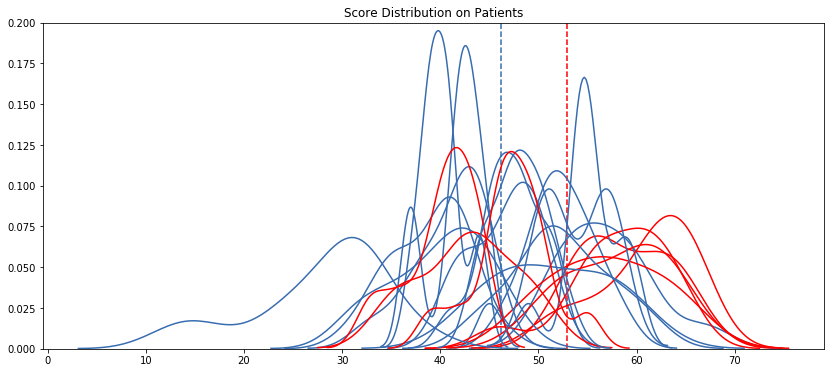

In [31]:
color_label = [color_ms if ms==1 else color_hc for ms in df_measures_users['ms']]
tab = list(zip(df_measures_users['userId'].values,color_label))
plt.figure(figsize=[14, 6]); plt.ylim(0,.2)
plt.title('Score Distribution on Patients')
for i in tab:
    df_user=df_measures[df_measures['userId']==str(i[0])]
    sns.kdeplot(df_user[score_variable], color=i[1], legend=False )

plt.vlines(x=df_ms[score_variable].mean(),ymin=0,ymax=.2, color=color_ms, linestyles='--', label='Mean MS')
plt.vlines(x=df_hc[score_variable].mean(),ymin=0,ymax=.2, color=color_hc, linestyles='--', label='Mean HC')

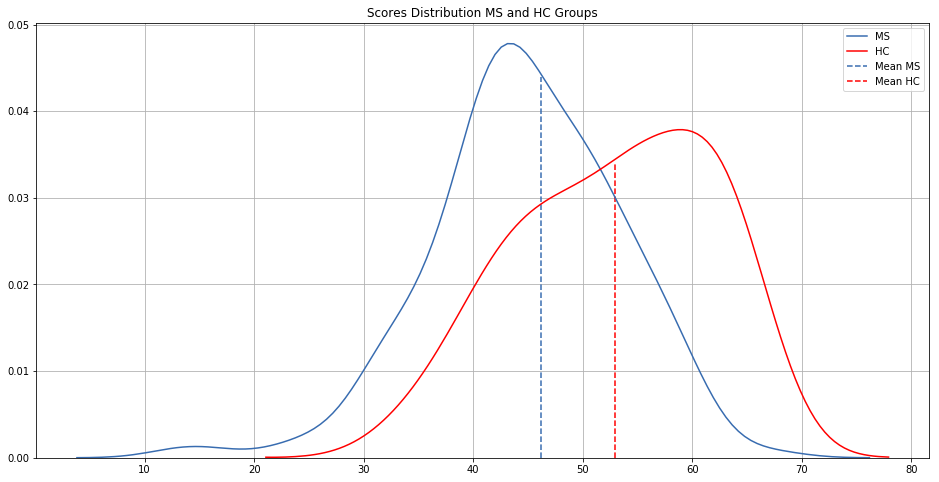

In [32]:
plt.figure(figsize=[16, 8])
sns.kdeplot(df_measures[df_measures['ms']==1][score_variable], color=color_ms, label='MS')
sns.kdeplot(df_measures[df_measures['ms']==0][score_variable], color=color_hc, label='HC')
plt.vlines(x=df_ms[score_variable].mean(),ymin=0,ymax=.044, color=color_ms, linestyles='--', label='Mean MS')
plt.vlines(x=df_hc[score_variable].mean(),ymin=0,ymax=.034, color=color_hc, linestyles='--', label='Mean HC')
plt.title('Scores Distribution MS and HC Groups')
plt.legend()
plt.grid()
plt.savefig('../reports/scores_distribution_grid.png')

As we can see both distributions looks pretty Gaussian, so we might perform a test to prove that all the scores of MS patients have a normal distribution, the same with HC participants

In [33]:
stats.mstats.normaltest(df_measures[df_measures['ms']==1][score_variable])

NormaltestResult(statistic=10.564380540924674, pvalue=0.0050812891979594953)

In [34]:
stats.mstats.normaltest(df_measures[df_measures['ms']==0][score_variable])

NormaltestResult(statistic=7.3069146189572232, pvalue=0.025901424559844673)

With the tests we see that the both scores variables are normally distributed, we might do point estimate

In [35]:
print('Mean MS: {} Interval: {}'.format(round(summary_ms.loc['mean'],2), interval_ms))
print('Mean HC: {} Interval: {}'.format(round(summary_hc.loc['mean'],2), interval_hc))

Mean MS: 46.22 Interval: [42.2359279085235, 50.211286981849291]
Mean HC: 52.92 Interval: [47.223154935582976, 58.613704038776]


At this point it does not seems to be any difference in standard deviation on both groups, is clear to see an important difference between the 2 groups on average score

|Experiment|Mean Tests Performed| Mean Scores|Standar Error|
|--|--|--|--|
|MS: 15 (65%)|11.93 (SD 4.59)|46.22 (SD 7.88)|2.03|
|HC: 8 (35%)|8.35 (SD 3.11)|52.92 (SD 8.22)|2.91|

---

## 2. Methods

### 2.1 Test-Retest Reliability

It measures test consistency, the reliability of a test measured over time. In other words, give the same test twice to the same people at different times to see if the scores are the same. For example, test on a Monday, then again the following Monday. The two scores are then correlated

**Make the same measure no matter when is taken over the time**

In [36]:
group = df_measures_users['userId'].tolist()

In [37]:
df_scores = ms_builder.scores_table(score_variable, group)
df_scores['ms'] = df_measures_users['ms']

Average Days Between Test-retest: 14.7 (SD): 3.21


In [38]:
df_scores

,userId,test,re-test,ms
0,3ZJxRxNFMbsihHc9n,41,47,1.0
1,3sLik5kugaynxduWs,55,57,0.0
2,6tzxzhSYpdi74TZth,52,55,1.0
3,7wCDFJMaqeZnFT93S,47,52,1.0
4,9BjE8bBgbi878bLbK,45,60,1.0
5,9G6ytzP9qiBSRDeCF,52,57,0.0
6,BcKgfS2coGNzsd4vJ,41,41,1.0
7,Dzk7fSkuN94xGo2Nn,52,60,0.0
8,KoSvgxuF5KGjvL2g3,49,63,0.0
9,Ls3zGvJ7wv3w3m665,37,43,1.0


We see the 23 participants with their own test and retest score, ms=1 refering the participants with ms

In [39]:
df_scores_ms = df_scores[df_scores['ms']==1]
df_scores_hc = df_scores[df_scores['ms']==0]

In [40]:
re_ms ,_1 = stats.pearsonr(df_scores_ms['test'], df_scores_ms['re-test'])
re_hc ,_2 = stats.pearsonr(df_scores_hc['test'], df_scores_hc['re-test'])
print ('Test-Retest Reliability:\n MS: {}   p-value: {}\n HC: {}   p-value: {}'.format(
    round(re_ms,2),_1 ,round(re_hc,2) ,_2))


Test-Retest Reliability:
 MS: 0.84   p-value: 8.496653745316737e-05
 HC: 0.85   p-value: 0.006935033738858537


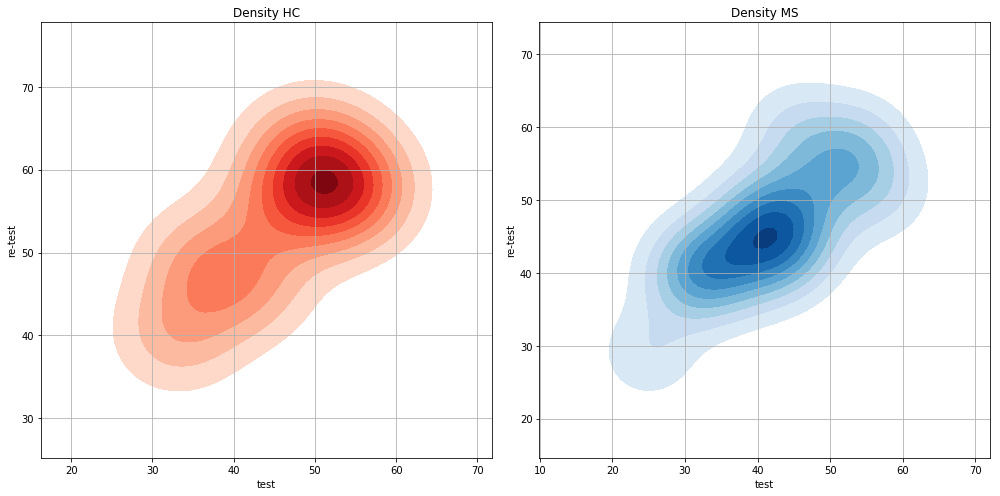

In [41]:
plt.figure(figsize=[14, 7])
plt.subplot(1,2,1); plt.grid()
sns.kdeplot(df_scores_hc['test'], df_scores_hc['re-test'], cmap="Reds", shade=True, shade_lowest=False)
plt.title('Density HC')
plt.subplot(1,2,2); plt.grid()
sns.kdeplot(df_scores_ms['test'], df_scores_ms['re-test'], cmap="Blues", shade=True, shade_lowest=False)
plt.title('Density MS')
plt.tight_layout()
plt.savefig('../reports/test-retest_density_grid.png')

Is it possible to see the correlation between test and retest on both groups, also is intuitive to see that people is scorimng more on the second one, showing an effect of improving

###  2.2 Standar Error of Measurement Based on Reliability

This statistical measure It gives the margin of error that you should expect in an individual test score because of the imperfect reliability of the test. The SEM represents the degree of confidence that a person's "true" score lies within a particular range of scores. For example, a SEM of "2" indicates that a test taker's "true" score probably lies within 2 points in either direction of the score he or she receives on the test. This means that if an individual receives a 91 on the test, there is a good chance that the person's "true" score lies somewhere between 89 and 93.

$$ SEM= s_X \sqrt(1-r) $$

In [42]:
sem_ms = df_scores_ms.describe().loc['std'].mean()*sqrt(1-re_ms)
sem_hc = df_scores_hc.describe().loc['std'].mean()*sqrt(1-re_hc)
print('Standar Error of Measurement: \n MS: {}\n HC: {}'.format(sem_ms, sem_hc))

Standar Error of Measurement: 
 MS: 2.274577217805805
 HC: 2.004522634546915


In [43]:
int_mdc_ms = [df_measures[df_measures['ms']==1][score_variable].mean() - (sem_ms*1.96),
              df_measures[df_measures['ms']==1][score_variable].mean() + (sem_ms*1.96)]
int_mdc_hc = [df_measures[df_measures['ms']==0][score_variable].mean() - (sem_hc*1.96),
              df_measures[df_measures['ms']==0][score_variable].mean() + (sem_hc*1.96)]

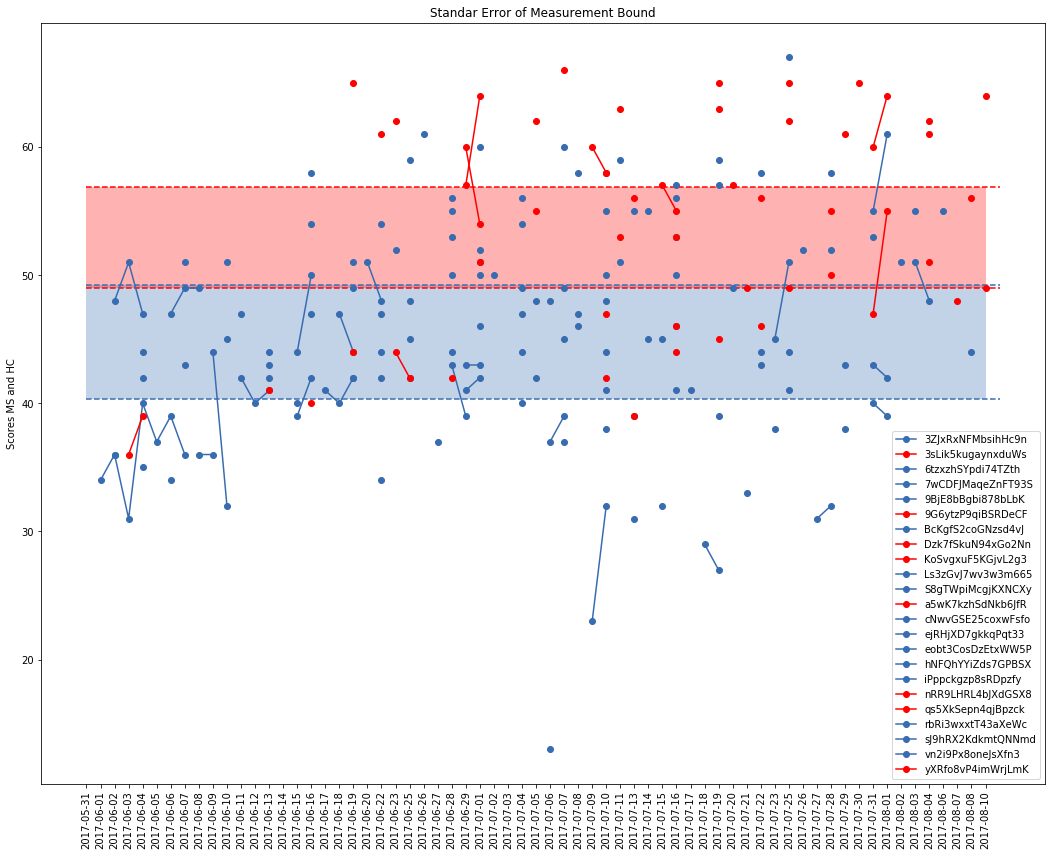

In [98]:
users = list(zip(df_measures_users['userId'], [color_ms if ms==1 else color_hc for ms in df_measures_users['ms']]))
ranges = (range(len(df_series)))
plt.figure(figsize=[18, 14])
for user in users:
    df_user = df_series[str(user[0])]
    plt.plot(range(len(df_user)), df_user, 'o-', color=user[1])

plt.hlines(y=[int_mdc_ms[0], int_mdc_ms[1]],xmin=0,xmax=len(df_series), color=color_ms, linestyles='--')
plt.hlines(y=[int_mdc_hc[0], int_mdc_hc[1]],xmin=0,xmax=len(df_series), color=color_hc, linestyles='--')
plt.fill_between(ranges, int_mdc_ms[0], int_mdc_ms[1], facecolor=color_ms, alpha=0.3)
plt.fill_between(ranges, int_mdc_hc[0], int_mdc_hc[1], facecolor=color_hc, alpha=0.3)
plt.xticks(ranges, df_series.index, rotation=90)
plt.title('Standar Error of Measurement Bound')
plt.ylabel('Scores MS and HC')
plt.legend(loc= 'Best')
plt.show()

### 2.4 Minimal Detectable Change

The MDC, representing the magnitude of change necessary to exceed the measurement
the error of two repeated measures at a specified CI was calculated for the 95% CI as:
$$MDC_{95} = SEM( 1.96 )(\sqrt{2})$$

1.96 is the two-sided tabled z value for the 95% CI and √
2 is used to account for the variance
of two measurements.

In [99]:
print('Minimal Detectable Change: \n MS: {} \n HC: {}'.format(stms.MDC(sem_ms).compute_mdc()
                                                              ,stms.MDC(sem_hc).compute_mdc()))

Minimal Detectable Change: 
 MS: 6.304806382168228 
 HC: 5.556253267885786


It means that if a measure is more than that so it's an outlier

The percentage of points outside of the MDC is:

Patient: 3ZJxRxNFMbsihHc9n Outside = 0.0%:
Patient: 3sLik5kugaynxduWs Outside = 0.0%:
Patient: 6tzxzhSYpdi74TZth Outside = 9.09%:
Patient: 7wCDFJMaqeZnFT93S Outside = 0.0%:
Patient: 9BjE8bBgbi878bLbK Outside = 8.33%:
Patient: 9G6ytzP9qiBSRDeCF Outside = 14.29%:
Patient: BcKgfS2coGNzsd4vJ Outside = 0.0%:
Patient: Dzk7fSkuN94xGo2Nn Outside = 0.0%:
Patient: KoSvgxuF5KGjvL2g3 Outside = 25.0%:
Patient: Ls3zGvJ7wv3w3m665 Outside = 0.0%:
Patient: S8gTWpiMcgjKXNCXy Outside = 8.33%:
Patient: a5wK7kzhSdNkb6JfR Outside = 16.67%:
Patient: cNwvGSE25coxwFsfo Outside = 37.5%:
Patient: ejRHjXD7gkkqPqt33 Outside = 23.08%:
Patient: eobt3CosDzEtxWW5P Outside = 22.73%:
Patient: hNFQhYYiZds7GPBSX Outside = 7.69%:
Patient: iPppckgzp8sRDpzfy Outside = 10.53%:
Patient: nRR9LHRL4bJXdGSX8 Outside = 25.0%:
Patient: qs5XkSepn4qjBpzck Outside = 11.11%:
Patient: rbRi3wxxtT43aXeWc Outside = 0.0%:
Patient: sJ9hRX2KdkmtQNNmd Outside = 20.0%:
Patient: vn2i9Px8oneJsXfn3 Outside = 0.0%:
Patient: yXRfo8vP4imWrjLmK Outside

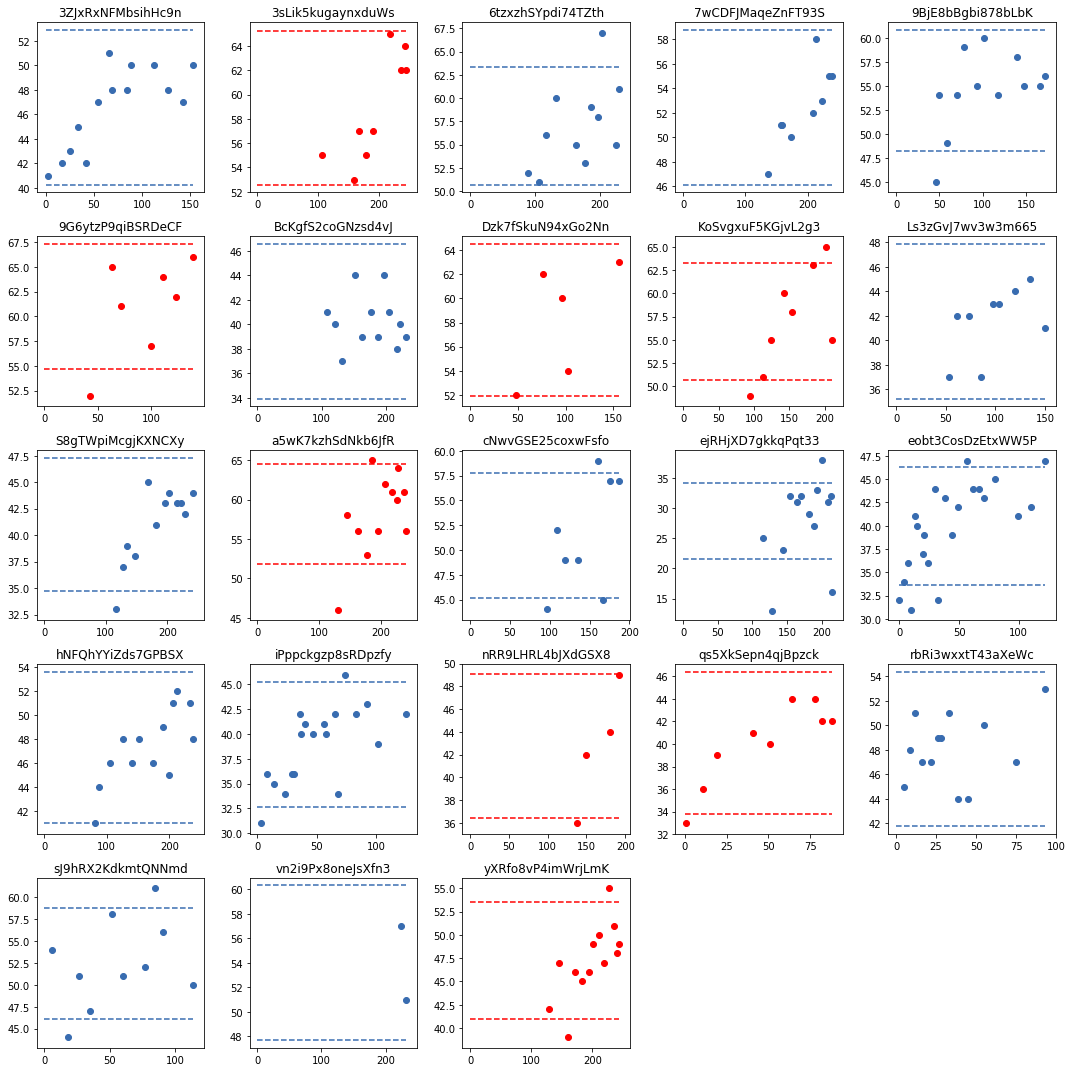

In [53]:
color_label = [color_ms if ms==1 else color_hc for ms in df_measures_users['ms']]
tab = list(zip(df_measures_users['userId'].values,color_label))

plt.figure(figsize=[15, 15])
for idx, i in enumerate(tab):
    plt.subplot(5,5,idx+1)
    df_user=df_measures[df_measures['userId']==str(i[0])]
    int_mdc_user, prop_user = stms.MDC(sem_ms).interval_mdc(df_user[score_variable])
    plt.hlines(y=int_mdc_user,xmin=0,xmax=df_user.index.values[-1], color=i[1], linestyles='--')
    plt.scatter(df_user.index, df_user[score_variable], color=i[1])
    print('Patient: {} Outside = {}%:'.format(i[0],round(prop_user,2)))
    plt.title(str(i[0]))

plt.tight_layout()

### 2.3 Internal Consistency

Internal consistency is usually measured with Cronbach's alpha, a statistic calculated from the pairwise correlations between items. Internal consistency ranges between negative infinity and one. Coefficient alpha will be negative whenever there is greater within-subject variability than between-subject variability, [more](https://www.ncbi.nlm.nih.gov/pubmed/1792347)

Cronbach's alpha factor
$$
\alpha = \dfrac{k\bar{r}}{(1+(k-1)\bar{r})}
$$

$k=$Number of items, or case tests over the time   
$r=$Non concurrent mean over the correlations coefficients of the tests   

In [39]:
k=2; re=(re_ms+re_ms)/2
c_alpha = (k*re)/(1+(k-1)*re)
print('Cronbach´s Alpha: {}'.format(c_alpha))

Cronbach´s Alpha: 0.9137462877117076


---

## 3. Results

##### Comparative Table Among Literature

| Source| Number of Patients on Study| Test-Retest Reliability Coefficient | Time for Re-Test | Average Scores per Group | Internal Consistency |
|:---:|:---:|:---:|:---:|:---:|:---:|
| (Benedict 2016) | $HC = NA$, $MS=34$ | $r_{HC}=0.76$, $r_{MS}=0.97$ | 2 Weeks | $NA$ | $NA$ |
| (Drake 2010) | $HC=100, MS=400$ | $r_{HC}=0.84$, $r_{MS}=0.74$ | 2.3 Years (SD 1.2)  | $NA$ | $NA$ |
| (Ruet 2013) | $HC=68$, $MS=101$ | $r_{HC}=0.83$, $r_{MS}=0.90$ | 6 Months | $47.6$ | $\alpha = 0.94$ |
| (Akbar 2011) | $HC=38$, $MS=119$ | $ICC=0.94$  | 103 Days (SD 16) | $HC=57.6$, $MS=45.1$ | $NA$ |
| (Sonder 2013) | $NA$ | $r=0.868$ |$NA$|$NA$|$NA$|
| (Beochet 2013) |$NA$|$NA$|$NA$|$NA$| $\alpha=0.96$ |
| **Orikami** | $HC=8$, $MS=15$ | $r_{HC}=0.85$, $r_{MS}=0.84$ | 14 Days (SD 3.2) | $HC=52.92$ $MS=46.11$ | $\alpha=0.91$


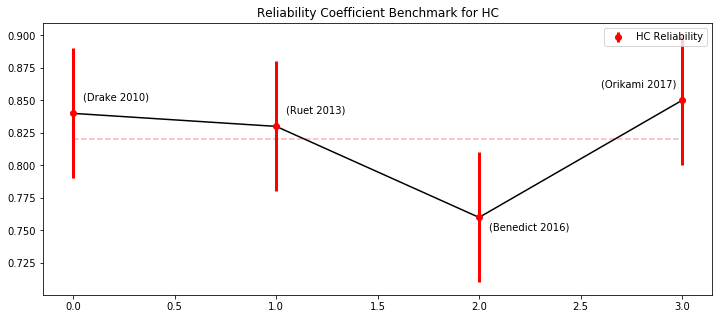

In [147]:
y=[0.84,0.83,0.76,0.85]; x=list(range(len(y)))
top = [i+0.05 for i in y]; bot = [i-0.05 for i in y]; inter = list(zip(bot,top))
plt.figure(figsize=(12,5))
plt.errorbar(x,y,yerr=[(top-bot)/2 for top,bot in inter], fmt='o', label='HC Reliability', color=color_hc, linewidth=3)
plt.plot(x,y, color='black'); plt.legend(); plt.title('Reliability Coefficient Benchmark for HC')
plt.hlines(y=sum(y)/len(y),xmin=0,xmax=x[-1], color=color_hc, linestyles='--', alpha=0.3)
plt.text(x[0]+.05, y[0]+.01, '(Drake 2010)')
plt.text(x[1]+.05, y[1]+.01, '(Ruet 2013)')
plt.text(x[2]+.05, y[2]-.01, '(Benedict 2016)')
plt.text(x[2]+.6, y[3]+.01, '(Orikami 2017)')

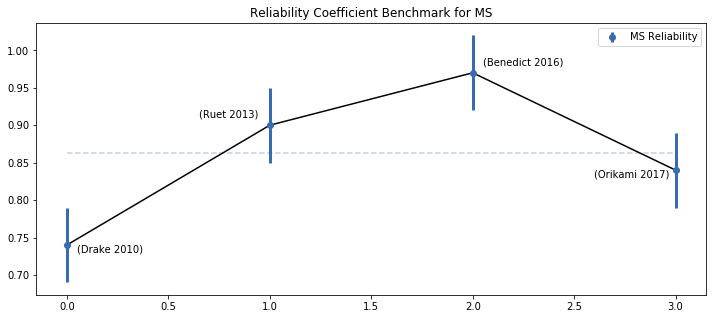

In [146]:
y=[0.74,0.90,0.97,0.84]; x=list(range(len(y)))
top = [i+0.05 for i in y]; bot = [i-0.05 for i in y]; inter = list(zip(bot,top))
plt.figure(figsize=(12,5))
plt.errorbar(x,y,yerr=[(top-bot)/2 for top,bot in inter], fmt='o', label='MS Reliability', color=color_ms, linewidth=3)
plt.plot(x,y, color='black'); plt.legend(); plt.title('Reliability Coefficient Benchmark for MS')
plt.hlines(y=sum(y)/len(y),xmin=0,xmax=x[-1], color=color_ms, linestyles='--', alpha=0.3)
plt.text(x[0]+.05, y[0]-.01, '(Drake 2010)')
plt.text(x[1]-.35, y[1]+.01, '(Ruet 2013)')
plt.text(x[2]+.05, y[2]+.01, '(Benedict 2016)')
plt.text(x[2]+.6, y[3]-.01, '(Orikami 2017)')

##### International Benchmark

|Source|Measure| Number of Participants |
|:---:|:---:|:---:|
|BICAMS (Benedict 2012)|People on HC | 65|
|**Orikami**|People on HC | 8|

|Source|Time elapsed for Re-Test |
|:---:|:---:|
|BICAMS (Benedict 2012) | 1-3 Weeks|
|**Orikami**| 14.7 (SD) 3.21 |

|Source|Measure| Reliability Coefficient |
|---|---|---|
|BICAMS (Benedict 2012) |Adequade | r > 0.7 |
|BICAMS (Benedict 2012) |Good | r > 0.80|
|**Orikami** |Good | r = 0.85 |

---
## 4. Conclusion

On the study the recomendations it's been followed in order to accomplish the correct Reliability of the expermiment and after watch the results we might say that the test is Reliable there's only the consideration on the number of participants to perform the study